In [2]:
import numpy as np
import os
import glob
from PIL import Image as PI
import matplotlib.pyplot as plt

In [3]:
def load_train_data():

    train_x = []
    train_y = []

    image_names = []
    folders = glob.glob("../Training/*")
#    for folder in folders:
    for i in range(1):
        for file in glob.glob(folders[i] + '/*.jpg'):
            image_names.append(file)
            with open(os.path.join(file), 'rb') as i:
                img = PI.open(i)
                img_sequence = img.getdata()
                img_array = np.array(img_sequence)
                train_x.append(img_array)

            dir_path = os.path.dirname(file)
            folder_name = os.path.basename(dir_path)
            train_y.append(folder_name)

    return np.array(train_x), np.array([train_y])

In [4]:
def init_parameters_deep(layer_dims):
    np.random.seed(3)

    parameters = {}

    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [5]:
# Linear part of the layer's forward propagation.
def linear_forward(A, W, b):

    Z = np.dot(W, A) + b

    cache = (A, W, b)

    return Z, cache


In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache
        

In [7]:
def sigmoid(Z):   
    A = 1/(1+np.exp(-Z))
    
    cache = Z
    
    return A, cache

In [8]:
def relu(Z): 
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
        
    cache = Z
    
    return A, cache

In [9]:
def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [10]:
def relu_backward(dA, cache):
    Z = cache
    
    dZ = np.array(dA, copy=True) # Set dz to correct object.
    
    dZ[Z <= 0] = 0
    
    assert(dZ.shape == Z.shape)
    
    return dZ

In [11]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
#     print("Inside l model forward, L: ", L)
    
    for l in range(1, L):
        A_prev = A
        
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, "relu")
        caches.append(cache)
        
    
    W = parameters["W" + str(L)]
    b = parameters["b" + str(L)]
    AL, cache = linear_activation_forward(A, W, b, "sigmoid")
    
    caches.append(cache)
    
    return AL, caches

In [12]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    logprobs = np.multiply(Y, np.log(AL)) + (1 - Y) * (np.log(1 - AL))
    
    cost = - np.sum(logprobs)/m
    
    cost = np.squeeze(cost)
    
    return cost

In [13]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    
    m = A_prev.shape[1]
    
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True) # sum by the rows of dZ with keepdims=True
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [15]:
def L_model_backward(AL, Y, caches):
    grads = {}
    
    L = len(caches)
#     print("L model backward, L: ", L)
    
    m = AL.shape[1]
#     print("AL shape: ", AL.shape)
#     print("L model backward, m: ", m)
    
#     print("L model backward, Y before reshape: ", Y.shape)
    Y = Y.reshape(AL.shape)
#     print("L model backward, Y after reshape: ", Y.shape)
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
          
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp


    return grads

In [16]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters 

In [17]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost=False):
    parameters = init_parameters_deep(layers_dims)
    
    costs = []
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
                
        cost = compute_cost(AL, Y)
         
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # Plot the cost.
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs

In [18]:
def init_int_mapping_y(train_y):
    
    # Get list of all types of fruit/veg.
    folders = glob.glob("../Training/*")
    words_y = []
    
    for folder in folders:
        dir_path = os.path.basename(folder)
        words_y.append(dir_path)
    
    words_y.sort()
    
    # Get num training examples and num of possible answers.
    m = train_y.shape[1]
    num_possible_answers = len(words_y)
    
    # Create a word to int dict for every type of fruit/veg.
    word_to_int_y = {}
    for i in range(num_possible_answers):
        key = "[\'" + words_y[i] +    "\']"
        word_to_int_y[key] = i
        
        
    # Create a list of ints mapped from fruits and veg. Size is equal to m.
    new_int_y = []
    for word in train_y.T:
        key = np.array2string(word)
        int_y = word_to_int_y[key]
        new_int_y.append(int_y)
    
    # Initliaise array of zeros with dims: possible_answers x m
    final_init_y = np.zeros((num_possible_answers, m))
    print("zeros shape: ", final_init_y.shape)
    
    # Initalise "1" for the "ith" position in each training example.
    # The position of the "1" represents the fruit or vegetable.
    i = 0
    for single_zero_array, y_int_mapping in zip(final_init_y.T, new_int_y):
        single_zero_array[y_int_mapping] = 1
    
    
#     (unique, count) = np.unique(zeros, return_counts=True)
    
#     print("unique: ", unique)
#     print("count: ", count)
    
    
    return final_init_y



    

loading training data...
train_x original:  (479, 10000, 3)
train_y original:  (1, 479)
train_x after flatten:  (30000, 479)
zeros shape:  (131, 479)
Y shape after int init:  (131, 479)
# layers L:  3
# training examples:  479
# output values:  131
Running model...
Cost after iteration 0: 90.800148
Cost after iteration 100: 0.006619
Cost after iteration 200: 0.002772
Cost after iteration 300: 0.001703
Cost after iteration 400: 0.001212
Cost after iteration 500: 0.000934
Cost after iteration 600: 0.000756
Cost after iteration 700: 0.000633
Cost after iteration 800: 0.000543
Cost after iteration 900: 0.000474
Cost after iteration 1000: 0.000421
Cost after iteration 1100: 0.000377
Cost after iteration 1200: 0.000342
Cost after iteration 1300: 0.000312
Cost after iteration 1400: 0.000287
Cost after iteration 1500: 0.000265
Cost after iteration 1600: 0.000247
Cost after iteration 1700: 0.000230
Cost after iteration 1800: 0.000216
Cost after iteration 1900: 0.000203
Cost after iteration 2000

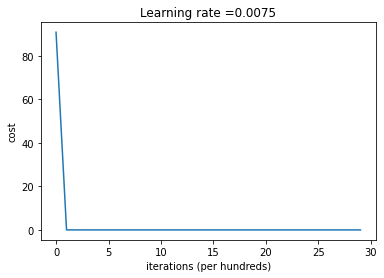

Model complete...


In [19]:
if __name__ == "__main__":
    # Load training data.
    train_x, train_y = load_train_data()
    print("loading training data...")
    print("train_x original: ", train_x.shape)
    print("train_y original: ", train_y.shape)

    # Flatten train_x (every col is a training example) and normalise values to a range between 0 and 1.
    train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
    train_x = train_x_flatten / 255
    print("train_x after flatten: ", train_x_flatten.shape)
    
    # Map train_y to array of integer values
    train_int_y = init_int_mapping_y(train_y)
    print("Y shape after int init: ", train_int_y.shape)

    # 3 layer network. Input layer = 100 pixels x 100 pixels x 3 rgb. Output layer = 131 = # possible fruits/veg.
    layer_dims = [30000, 20, 20, 131]
    parameters = init_parameters_deep(layer_dims)
    print("# layers L: ", len(parameters)//2)
#     for k, v in parameters.items():
#         print("key: ", k)
#         print("value shape: ", v.shape)
    
    print("# training examples: ", train_x.shape[1])
    print("# output values: ", train_int_y.shape[0])
        
    print("Running model...")
    # L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost=False)
    parameters, costs = L_layer_model(train_x, train_int_y, layer_dims, 0.0075, num_iterations=3000, print_cost=True)
    print("Model complete...")
    
    
    
        